In [1]:
import pandas as  pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity 
import seaborn as sn 
import matplotlib.pyplot as plt
import difflib

In [2]:
df = pd.read_csv('Football_Final_Dataset_10000.csv')

In [3]:
df

,Player Name,Age-old,Age,Position,Matches Started,Played,Minutes Played,Goals,Expected Goals(xG),xG on target,...,Aerial Duels won %,Interceptions,Blocked,Fouls committed,Recoveries,Possession won final 3rd,Dribbled past,Yellow Cards,Red Cards,Season
0,Pau Cubarsí,18,18,Defender,35.0,NaN,2450,0,0.90,0.00,...,58.3,16.0,2.0,24.0,102.0,0.0,11.0,3.0,0.0,2024-2025
1,Alejandro Balde,21,21,Defender,32.0,NaN,2240,0,0.48,0.00,...,64.0,5.0,3.0,16.0,122.0,0.0,6.0,2.0,0.0,2024-2025
2,Ronald Araújo,26,26,Defender,12.0,NaN,840,1,0.95,0.76,...,61.1,9.0,0.0,9.0,27.0,0.0,1.0,3.0,0.0,2024-2025
3,Iñigo Martínez,34,34,Defender,28.0,NaN,1960,0,0.49,0.17,...,64.5,18.0,6.0,18.0,126.0,0.0,6.0,5.0,0.0,2024-2025
4,Andreas Christensen,29,29,Defender,5.0,NaN,350,0,0.02,0.00,...,68.8,4.0,5.0,0.0,14.0,0.0,0.0,3.0,0.0,2024-2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185,Lucas Pérez,34,37,Forward,7.0,17.0,2540,15,22.20,13.80,...,16.0,17.0,15.0,3.0,7.0,27.0,1.0,10.0,1.0,2024-2025
1186,Andrea Petagna,27,30,Forward,29.0,24.0,1224,24,16.80,6.80,...,59.3,26.0,35.0,60.0,105.0,8.0,1.0,10.0,0.0,2024-2025
1187,Nils Petersen,34,37,Forward,19.0,15.0,1609,26,9.80,27.60,...,39.5,37.0,40.0,35.0,16.0,18.0,23.0,4.0,1.0,2024-2025
1188,Luca Pfeiffer,26,29,Forward,16.0,24.0,1537,10,1.80,10.30,...,16.1,32.0,17.0,56.0,54.0,1.0,17.0,7.0,0.0,2024-2025


In [4]:
df.drop_duplicates(inplace=True)
df.fillna(0,inplace=True)

In [5]:
df['Position'] = df['Position'].str.strip().str.upper()

In [6]:
print(df['Position'].unique())

['DEFENDER' 'MIDFIELDER' 'FORWARD']


In [7]:
#Define per-90 Features
df['Goal per 90'] = df['Goals']/df['Minutes Played'] * 90
df['xG per 90'] = df['Expected Goals(xG)'] / df['Minutes Played'] * 90
df['Assists per 90'] = df['Assists'] / df['Minutes Played'] * 90
df['Passes per 90'] = df['Successful passes'] / df['Minutes Played'] * 90

In [8]:
#Create Contextual Composite Feature
df['Goal Conversion Rate'] = df['Goals'] / df['Shots']
df['Shooting Accuracy'] = df['Shots on target'] / df['Shots']
df['Touch Efficiency'] = df['Goals'] / df['Touches in opposition box']
df['Chance Creation Index'] = df['Assists'] + df['Chances Created'] + df['Expected Assists']
df['Progressive Passes'] = df['Accurate Long Balls'] * df['Long Ball Accuracy']
df['Dribble Efficiency'] = df['Successful dribbles'] / (df['Successful dribbles'] + df['Dribbled past'])
df['Duels per Minute'] = df['Duels Won'] / df['Minutes Played']
df['Touches per Minute'] = df['Touches'] / df['Minutes Played']
df['Defensive Actions'] = df['Tackles Won'] + df['Interceptions'] + df['Blocked']
df['Defensive Efficiency'] = df['Defensive Actions'] / (df['Dispossessed'] + 1)
df['Aerial Efficiency'] = df['Aerial Duels won'] * df['Aerial Duels won %']

In [9]:
#Custom Position based Impact Score
#For Attacker 40% weight for Goal per 90 + 30% weight for xG per 90 + 30% weight for Touch Efficiency
df['Attacker Impact'] = (0.4 * df['Goal per 90'] + 0.3 * df['xG per 90'] + 0.3 * df['Touch Efficiency'])
#For Attacker 30% weight for Pass Accuracy + 25% weight for Expected Assists + 20% weight for Touches + 25% weight for Successfull Dribbles
df['Midfielder Impact'] = (0.3 * df['Pass Accuracy'] + 0.25 * df['Expected Assists'] + 0.2 * df['Touches'] + 0.25 * df['Successful dribbles'])
#For Attacker 40% weight for Tackles Won + 30% weight for Interceptions + 30% weight for Aerial Efficiency 
df['Defender Impact'] = (0.4 * df['Tackles Won'] + 0.3 * df['Interceptions'] + 0.3 * df['Aerial Efficiency'])

In [10]:
# Normalize relevant features by position
position_features = {
    'FORWARD': ['Goal per 90', 'xG per 90', 'Assists per 90',
    'Goal Conversion Rate', 'Shooting Accuracy', 'Touch Efficiency',
    'Dribble Efficiency', 'Attacker Impact', 'Duels per Minute',
    'Touches per Minute'],
    'MIDFIELDER': ['Pass Accuracy', 'Expected Assists', 'Assists per 90', 'Touches',
    'Chance Creation Index', 'Dribble Efficiency',
    'Progressive Passes', 'Midfielder Impact', 'Touches per Minute',
    'Passes per 90'],
    'DEFENDER': ['Tackles Won', 'Interceptions', 'Blocked', 'Defensive Actions',
    'Defensive Efficiency', 'Aerial Efficiency', 'Duels per Minute',
    'Touches per Minute', 'Defender Impact']
}

In [11]:
df

,Player Name,Age-old,Age,Position,Matches Started,Played,Minutes Played,Goals,Expected Goals(xG),xG on target,...,Progressive Passes,Dribble Efficiency,Duels per Minute,Touches per Minute,Defensive Actions,Defensive Efficiency,Aerial Efficiency,Attacker Impact,Midfielder Impact,Defender Impact
0,Pau Cubarsí,18,18,DEFENDER,35.0,0.0,2450,0,0.90,0.00,...,5542.8,0.352941,0.045306,1.156735,41.0,20.500000,3672.9,0.009918,596.6175,1115.87
1,Alejandro Balde,21,21,DEFENDER,32.0,0.0,2240,0,0.48,0.00,...,900.0,0.884615,0.052232,0.812500,18.0,0.642857,1024.0,0.005786,403.5650,312.70
2,Ronald Araújo,26,26,DEFENDER,12.0,0.0,840,1,0.95,0.76,...,1409.2,0.000000,0.058333,0.961905,18.0,9.000000,2016.3,0.106726,189.2325,611.19
3,Iñigo Martínez,34,34,DEFENDER,28.0,0.0,1960,0,0.49,0.17,...,8404.8,0.333333,0.058163,1.382143,38.0,9.500000,3870.0,0.006750,570.4325,1172.00
4,Andreas Christensen,29,29,DEFENDER,5.0,0.0,350,0,0.02,0.00,...,66.6,NaN,0.048571,0.702857,13.0,13.000000,756.8,0.001543,76.7575,229.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185,Lucas Pérez,34,37,FORWARD,7.0,17.0,2540,15,22.20,13.80,...,504.0,0.888889,0.021654,0.280709,39.0,1.695652,96.0,0.460211,167.6100,36.70
1186,Andrea Petagna,27,30,FORWARD,29.0,24.0,1224,24,16.80,6.80,...,4087.0,0.990476,0.206699,0.251634,84.0,2.333333,59.3,1.095319,115.2400,34.79
1187,Nils Petersen,34,37,FORWARD,19.0,15.0,1609,26,9.80,27.60,...,2752.0,0.752688,0.118086,1.205718,90.0,2.812500,1777.5,0.780239,431.3350,549.55
1188,Luca Pfeiffer,26,29,FORWARD,16.0,24.0,1537,10,1.80,10.30,...,528.0,0.811111,0.117111,0.297332,70.0,1.891892,837.2,0.283184,135.3250,269.16


In [12]:
def normalize_by_position(df, position_features):
    df_out = pd.DataFrame()
    for pos, feats in position_features.items():
        subset = df[df['Position'] == pos].copy()
        subset[feats] = StandardScaler().fit_transform(subset[feats])
        df_out = pd.concat([df_out, subset])
    return df_out.reset_index(drop=True)

In [13]:
df = normalize_by_position(df, position_features)

In [14]:
print("Positions in dataset:", df['Position'].unique())

Positions in dataset: ['FORWARD' 'MIDFIELDER' 'DEFENDER']


In [15]:
df

,Player Name,Age-old,Age,Position,Matches Started,Played,Minutes Played,Goals,Expected Goals(xG),xG on target,...,Progressive Passes,Dribble Efficiency,Duels per Minute,Touches per Minute,Defensive Actions,Defensive Efficiency,Aerial Efficiency,Attacker Impact,Midfielder Impact,Defender Impact
0,Ferran Torres,25,25,FORWARD,27.0,12.0,1100,10,7.95,6.46,...,160.0,-0.553674,-0.518015,-0.401304,18.000000,1.285714,178.500000,-0.232773,133.4850,56.350000
1,Robert Lewandowski,36,36,FORWARD,34.0,32.0,2681,27,27.11,25.87,...,576.4,-0.112904,-0.497734,-0.499247,33.000000,0.717391,1779.700000,-0.116502,216.9825,536.810000
2,Ansu Fati,22,22,FORWARD,6.0,3.0,232,0,0.98,0.77,...,0.0,0.232799,-0.392318,-0.177248,6.000000,1.200000,44.400000,-0.659791,63.3275,14.020000
3,Raphinha,28,28,FORWARD,36.0,32.0,2844,18,19.38,15.30,...,2714.0,-0.366419,-0.449302,-0.242262,60.000000,2.000000,540.000000,-0.346364,437.9775,174.100000
4,Pau Víctor,23,23,FORWARD,21.0,2.0,308,2,3.01,3.19,...,133.4,-0.486262,-0.418430,-0.304226,6.000000,0.666667,225.000000,-0.263978,64.7200,68.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185,Marin Pongra?i?,25,28,DEFENDER,33.0,37.0,2590,1,4.00,3.80,...,277.2,0.696429,0.011538,-0.103404,1.069078,-0.318715,1.449944,0.059765,498.9050,1.460081
1186,Jackson Porozo,22,25,DEFENDER,23.0,28.0,1960,0,3.50,0.10,...,8243.1,0.240000,-0.768735,-0.428161,0.154639,-0.397260,-0.709856,0.048214,304.2450,-0.700636
1187,Pedro Porro,23,26,DEFENDER,14.0,32.0,2240,1,4.00,0.60,...,10220.4,0.606061,-1.051160,0.014055,1.148594,-0.268341,-0.242246,0.067857,468.8900,-0.233340
1188,Stefan Posch,25,28,DEFENDER,16.0,28.0,1960,5,0.60,0.70,...,3931.2,0.428571,-0.032338,0.173297,-0.521251,-0.154829,0.214094,inf,441.3500,0.212440


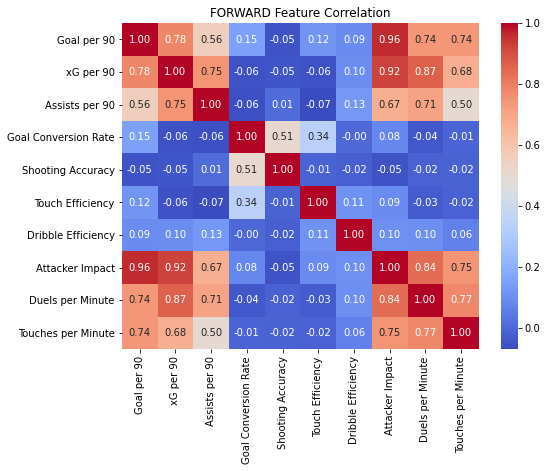

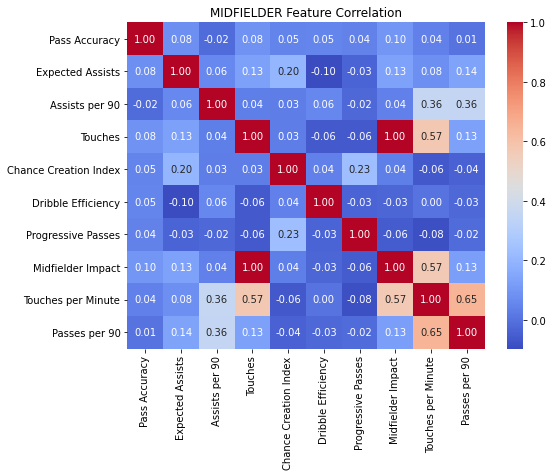

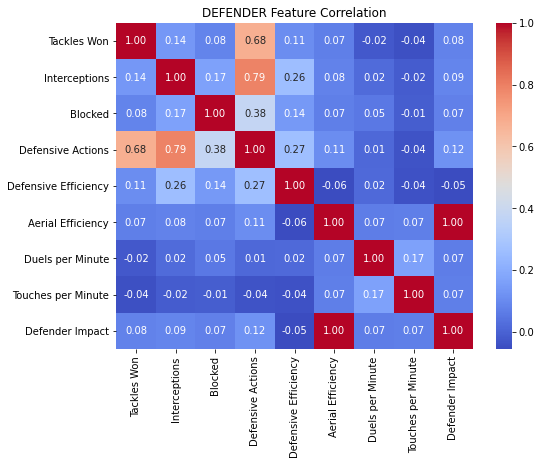

In [16]:
#Correlation Heatmap per Position
for pos, feats in position_features.items():
    subset = df[df['Position'] == pos]
    
    # Check if subset is empty
    if subset.empty:
        print(f"No data for {pos}")
        continue

    corr = subset[feats].corr()
    
    plt.figure(figsize=(8, 6))
    sn.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f"{pos} Feature Correlation")
    plt.show()

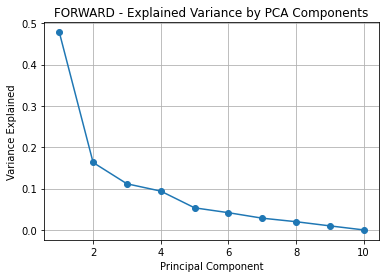


FORWARD Feature Contribution to PC1 (abs values):
Attacker Impact         0.442576
xG per 90               0.428738
Duels per Minute        0.421902
Goal per 90             0.411056
Touches per Minute      0.378797
Assists per 90          0.354347
Dribble Efficiency      0.061683
Shooting Accuracy       0.020553
Touch Efficiency        0.006658
Goal Conversion Rate    0.004603
dtype: float64


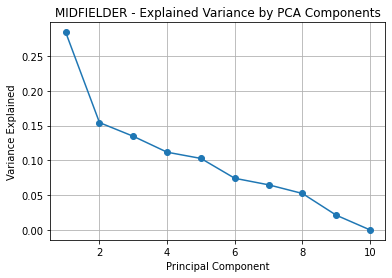


MIDFIELDER Feature Contribution to PC1 (abs values):
Touches per Minute       0.529177
Touches                  0.521697
Midfielder Impact        0.520549
Passes per 90            0.331510
Assists per 90           0.205351
Expected Assists         0.131599
Progressive Passes       0.080354
Dribble Efficiency       0.029468
Chance Creation Index    0.010986
Pass Accuracy            0.000747
dtype: float64


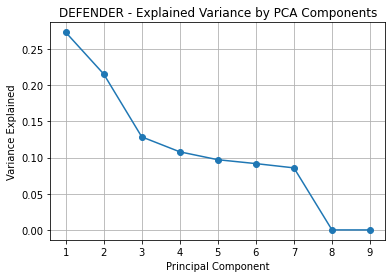


DEFENDER Feature Contribution to PC1 (abs values):
Defensive Actions       0.579345
Interceptions           0.454870
Tackles Won             0.373154
Defender Impact         0.313693
Aerial Efficiency       0.306992
Blocked                 0.276269
Defensive Efficiency    0.216737
Duels per Minute        0.047267
Touches per Minute      0.005297
dtype: float64


In [17]:
#PCA per Position
from sklearn.decomposition import PCA
for pos, feats in position_features.items():
    subset = df[df['Position'] == pos]

    # Drop NaNs
    X = subset[feats].dropna()
    
    if X.empty:
        print(f"Not enough data for PCA in {pos}")
        continue

    pca = PCA(n_components=len(feats))
    pca.fit(X)

    # Explained variance
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(feats)+1), pca.explained_variance_ratio_, marker='o')
    plt.title(f'{pos} - Explained Variance by PCA Components')
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained')
    plt.grid(True)
    plt.show()

    # Feature importance in PC1
    pc1_importance = pd.Series(pca.components_[0], index=feats)
    print(f"\n{pos} Feature Contribution to PC1 (abs values):")
    print(pc1_importance.abs().sort_values(ascending=False))

In [18]:
def get_similar_players(input_player, df, top_n=5):
    input_player = input_player.strip()
    
    if input_player not in df['Player Name'].values:
        raise ValueError(f"Player '{input_player}' not found in the dataset.")
    
    player_position = df.loc[df['Player Name'] == input_player, 'Position'].values[0]

    if player_position not in position_features:
        raise ValueError(f"No feature list defined for position '{player_position}'.")

    features = position_features[player_position]
    pos_df = df[df['Position'] == player_position].copy().reset_index(drop=True)

    scaler = StandardScaler()
    pos_df_scaled = scaler.fit_transform(pos_df[features])

    player_idx = pos_df[pos_df['Player Name'] == input_player].index[0]
    similarity = cosine_similarity([pos_df_scaled[player_idx]], pos_df_scaled)[0]

    pos_df['Similarity'] = similarity

    similar_players = pos_df[pos_df['Player Name'] != input_player] \
                        .sort_values(by='Similarity', ascending=False) \
                        .head(top_n)

    return similar_players[['Player Name', 'Position', 'Similarity']]

In [19]:
print("Welcome to the Player Similarity Finder!")
player_name = input("Enter the player name you want to find similar players for: ")

try:
    similar = get_similar_players(player_name, df)
    print(f"\nTop similar players to '{player_name}':\n")
    print(similar.to_string(index=False))
except ValueError as e:
    print("Error:", e)

Welcome to the Player Similarity Finder!
Enter the player name you want to find similar players for: Pedro Porro

Top similar players to 'Pedro Porro':

     Player Name Position  Similarity
    Brian Oliván DEFENDER    0.943162
          Felipe DEFENDER    0.926946
    Sael Kumbedi DEFENDER    0.907922
Andoni Gorosabel DEFENDER    0.895883
 Marcin Kami?ski DEFENDER    0.860960


In [20]:
!pip install protobuf==3.20.3



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
#Neural Networks
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
import numpy as np


def get_similar_players_nn(input_player, df, top_n=5, encoding_dim=3):
    input_player = input_player.strip()

    if input_player not in df['Player Name'].values:
        raise ValueError(f"Player '{input_player}' not found in the dataset.")
    
    player_position = df.loc[df['Player Name'] == input_player, 'Position'].values[0]

    if player_position not in position_features:
        raise ValueError(f"No feature list defined for position '{player_position}'.")

    features = position_features[player_position]
    pos_df = df[df['Position'] == player_position].copy().reset_index(drop=True)

    # Normalize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(pos_df[features])

    # --- Define Autoencoder ---
    input_dim = len(features)
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu',
                    activity_regularizer=regularizers.l1(1e-5))(input_layer)
    decoded = Dense(input_dim, activation='linear')(encoded)

    autoencoder = Model(inputs=input_layer, outputs=decoded)
    encoder = Model(inputs=input_layer, outputs=encoded)
    
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(scaled_features, scaled_features, epochs=100, batch_size=16, verbose=0)

    # --- Encode players ---
    embeddings = encoder.predict(scaled_features)

    # Get input player index and embedding
    player_idx = pos_df[pos_df['Player Name'] == input_player].index[0]
    input_embedding = embeddings[player_idx]

    # Compute Euclidean distances
    distances = np.linalg.norm(embeddings - input_embedding, axis=1)
    pos_df['Similarity'] = 1 / (1 + distances)  

    similar_players = pos_df[pos_df['Player Name'] != input_player] \
                        .sort_values(by='Similarity', ascending=False) \
                        .head(top_n)

    return similar_players[['Player Name', 'Position', 'Similarity']]

In [22]:
print("Welcome to the Neural Network Player Similarity Finder!")
player_name = input("Enter the player name you want to find similar players for: ")

try:
    similar = get_similar_players_nn(player_name, df)
    print(f"\nTop similar players to '{player_name}':\n")
    print(similar.to_string(index=False))
except ValueError as e:
    print("Error:", e)


Welcome to the Neural Network Player Similarity Finder!
Enter the player name you want to find similar players for: Pedro Porro
18/18 [==============================] - 0s 3ms/step

Top similar players to 'Pedro Porro':

   Player Name Position  Similarity
  Sael Kumbedi DEFENDER    0.801935
Angelo Ogbonna DEFENDER    0.739573
 Cédric Avinel DEFENDER    0.720235
   Arial Mendy DEFENDER    0.716308
  Brian Oliván DEFENDER    0.706535


In [23]:
from sklearn.metrics.pairwise import euclidean_distances

def evaluate_similarity_model(input_player, df, model_func, model_name, top_n=5):
    try:
        similar_players = model_func(input_player, df, top_n=top_n)
        position = df.loc[df['Player Name'] == input_player, 'Position'].values[0]
        features = position_features[position]
        
        input_vec = df[df['Player Name'] == input_player][features].values[0]
        avg_distance = 0
        
        for _, row in similar_players.iterrows():
            compare_vec = df[df['Player Name'] == row['Player Name']][features].values[0]
            dist = euclidean_distances([input_vec], [compare_vec])[0][0]
            avg_distance += dist
        
        avg_distance /= len(similar_players)
        
        print(f"{model_name} model - Avg distance for '{input_player}' to top {top_n} similar players: {avg_distance:.4f}")
        return avg_distance
    
    except Exception as e:
        print(f"{model_name} model failed for '{input_player}':", e)
        return None


Evaluating models on test players...

--- Evaluating for Robert Lewandowski ---
Cosine Similarity - Avg similarity to top 5: 0.8656
10/10 [==============================] - 0s 3ms/step
Neural Net - Avg similarity to top 5: 0.9190
--- Evaluating for Raphinha ---
Cosine Similarity - Avg similarity to top 5: 0.9711
10/10 [==============================] - 0s 4ms/step
Neural Net - Avg similarity to top 5: 0.9521
--- Evaluating for Virgil van Dijk ---
Cosine Similarity - Avg similarity to top 5: 0.8872
18/18 [==============================] - 0s 3ms/step
Neural Net - Avg similarity to top 5: 0.5975

--- Summary ---
Average Cosine Similarity across players: 0.9080
Average Neural Net similarity across players: 0.8229
✅ Cosine Similarity model performs better (higher avg similarity).


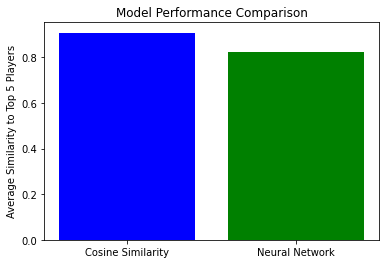

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# List of players to test
test_players = ['Robert Lewandowski', 'Raphinha', 'Virgil van Dijk']

# Store average similarity (or distance) results
cosine_results = []
nn_results = []

print("Evaluating models on test players...\n")

for player in test_players:
    print(f"--- Evaluating for {player} ---")

    # Evaluate Cosine Similarity model
    try:
        cosine_similar = get_similar_players(player, df, top_n=5)
        # Cosine similarity is higher when players are more similar, so avg similarity:
        avg_sim = cosine_similar['Similarity'].mean()
        cosine_results.append(avg_sim)
        print(f"Cosine Similarity - Avg similarity to top 5: {avg_sim:.4f}")
    except Exception as e:
        cosine_results.append(np.nan)
        print(f"Cosine Similarity model failed: {e}")

    # Evaluate Neural Network model
    try:
        nn_similar = get_similar_players_nn(player, df, top_n=5)
        # Similarity in NN code is computed as 1/(1+distance), higher means more similar
        avg_sim = nn_similar['Similarity'].mean()
        nn_results.append(avg_sim)
        print(f"Neural Net - Avg similarity to top 5: {avg_sim:.4f}")
    except Exception as e:
        nn_results.append(np.nan)
        print(f"Neural Net model failed: {e}")

print("\n--- Summary ---")

# Calculate mean similarity, ignoring failures (NaN)
mean_cosine = np.nanmean(cosine_results)
mean_nn = np.nanmean(nn_results)

print(f"Average Cosine Similarity across players: {mean_cosine:.4f}")
print(f"Average Neural Net similarity across players: {mean_nn:.4f}")

if mean_cosine > mean_nn:
    print("✅ Cosine Similarity model performs better (higher avg similarity).")
elif mean_nn > mean_cosine:
    print("✅ Neural Network model performs better (higher avg similarity).")
else:
    print("Both models perform equally well.")

# Optional: Visual comparison plot
labels = ['Cosine Similarity', 'Neural Network']
scores = [mean_cosine, mean_nn]

plt.bar(labels, scores, color=['blue', 'green'])
plt.ylabel('Average Similarity to Top 5 Players')
plt.title('Model Performance Comparison')
plt.show()


In [27]:
!pip install shap

     -------------------------------------- 450.3/450.3 kB 2.8 MB/s eta 0:00:00


     ---------------------------------------- 66.5/66.5 kB 1.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 20.9
    Uninstalling packaging-20.9:
      Successfully uninstalled packaging-20.9


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
streamlit 1.40.1 requires packaging<25,>=20, but you have packaging 25.0 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
from sklearn.neighbors import KNeighborsRegressor
import shap
import matplotlib.pyplot as plt

# 🔹 Player input
input_player = ['Robert Lewandowski', 'Raphinha', 'Virgil van Dijk']

if input_player not in df['Player Name'].values:
    print(f"Player '{input_player}' not found in dataset.")
else:
    player_position = df.loc[df['Player Name'] == input_player, 'Position'].values[0]

    if player_position not in position_features:
        print(f"No features defined for position '{player_position}'.")
    else:
        features = position_features[player_position]
        pos_df = df[df['Position'] == player_position].copy().reset_index(drop=True)

        # Normalize & keep feature names
        scaler = StandardScaler()
        X_scaled_np = scaler.fit_transform(pos_df[features])
        X_scaled = pd.DataFrame(X_scaled_np, columns=features)  # <-- DataFrame with feature names

        # Cosine similarity
        input_idx = pos_df[pos_df['Player Name'] == input_player].index[0]
        similarities = cosine_similarity([X_scaled_np[input_idx]], X_scaled_np)[0]
        pos_df['Similarity'] = similarities

        # Train surrogate KNN model
        knn = KNeighborsRegressor(n_neighbors=5)
        knn.fit(X_scaled, similarities)

        # SHAP with feature names
        explainer = shap.Explainer(knn.predict, X_scaled)
        shap_values = explainer(X_scaled)

        print(f"\n🔍 SHAP Explanation for Player: {input_player}")
        shap.plots.bar(shap_values[input_idx], max_display=10)     # Bar plot with names
        shap.plots.waterfall(shap_values[input_idx], max_display=10)  # Waterfall plot

Player '['Robert Lewandowski', 'Raphinha', 'Virgil van Dijk']' not found in dataset.


elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Enter Player Name: Robert Lewandowski
10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer: 306it [03:06,  1.56it/s]                         



🔍 SHAP Explanation for Neural Network Similarity - Player: Robert Lewandowski


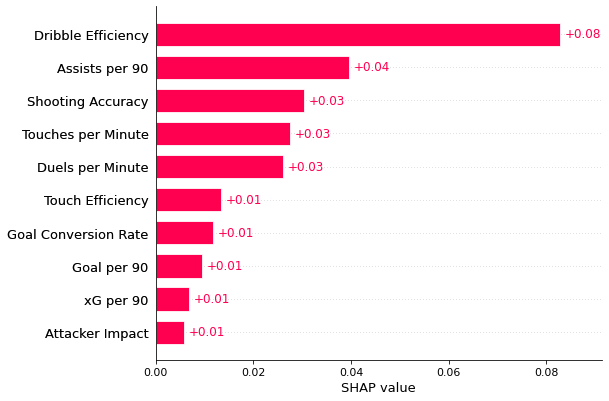

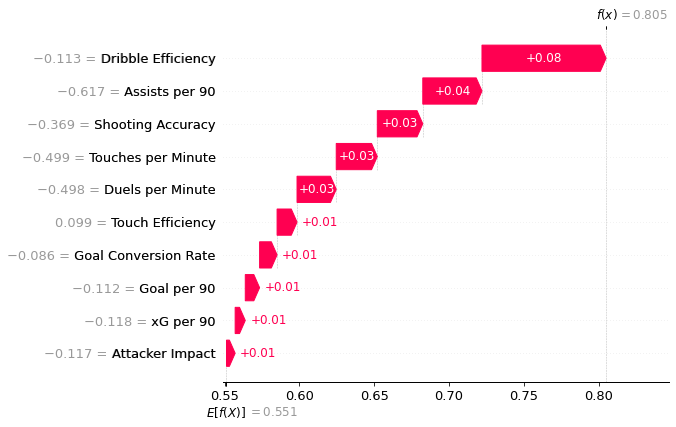

In [32]:
from sklearn.neighbors import KNeighborsRegressor
import shap
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
import numpy as np

# Player input
input_player = input("Enter Player Name: ").strip()

if input_player not in df['Player Name'].values:
    print(f"Player '{input_player}' not found in dataset.")
else:
    player_position = df.loc[df['Player Name'] == input_player, 'Position'].values[0]

    if player_position not in position_features:
        print(f"No features defined for position '{player_position}'.")
    else:
        features = position_features[player_position]
        pos_df = df[df['Position'] == player_position].copy().reset_index(drop=True)

        # Normalize & retain feature names
        scaler = StandardScaler()
        X_scaled_np = scaler.fit_transform(pos_df[features])
        X_scaled = pd.DataFrame(X_scaled_np, columns=features)

        # --- Autoencoder for Embedding ---
        input_dim = len(features)
        encoding_dim = 3
        input_layer = Input(shape=(input_dim,))
        encoded = Dense(encoding_dim, activation='relu',
                        activity_regularizer=regularizers.l1(1e-5))(input_layer)
        decoded = Dense(input_dim, activation='linear')(encoded)

        autoencoder = Model(inputs=input_layer, outputs=decoded)
        encoder = Model(inputs=input_layer, outputs=encoded)

        autoencoder.compile(optimizer='adam', loss='mse')
        autoencoder.fit(X_scaled_np, X_scaled_np, epochs=100, batch_size=16, verbose=0)

        # Get embeddings from encoder
        embeddings = encoder.predict(X_scaled_np)

        # Compute Euclidean distances in embedding space
        input_idx = pos_df[pos_df['Player Name'] == input_player].index[0]
        input_embedding = embeddings[input_idx]
        distances = np.linalg.norm(embeddings - input_embedding, axis=1)
        similarity_scores = 1 / (1 + distances)

        # Train surrogate KNN model for SHAP
        knn = KNeighborsRegressor(n_neighbors=5)
        knn.fit(X_scaled, similarity_scores)

        # SHAP analysis
        explainer = shap.Explainer(knn.predict, X_scaled)
        shap_values = explainer(X_scaled)

        print(f"\n🔍 SHAP Explanation for Neural Network Similarity - Player: {input_player}")
        shap.plots.bar(shap_values[input_idx], max_display=10)     # Bar plot
        shap.plots.waterfall(shap_values[input_idx], max_display=10)  # Waterfall plot



Processing SHAP for: Robert Lewandowski


ExactExplainer explainer: 306it [03:02,  1.58it/s]                         


🔍 SHAP Explanation for Player: Robert Lewandowski


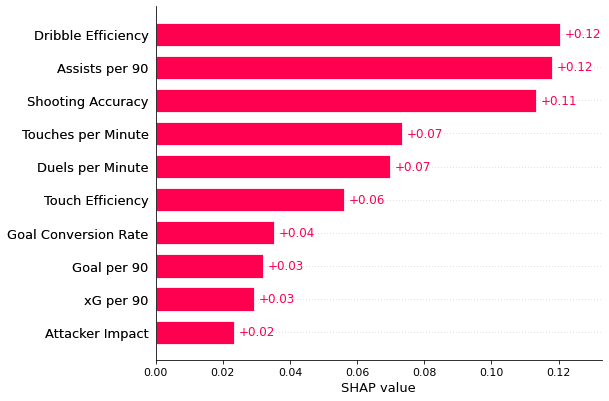

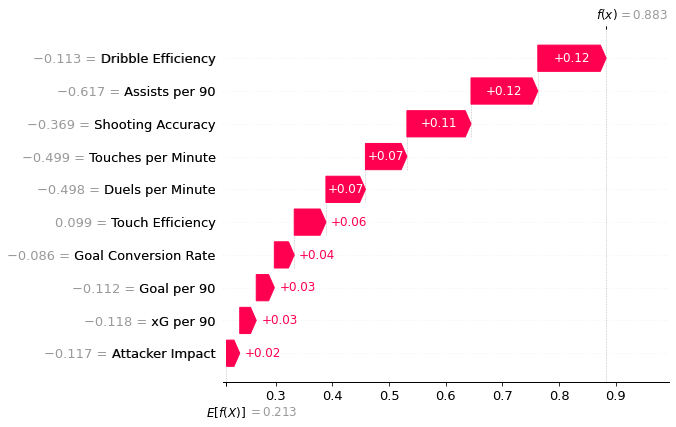


Processing SHAP for: Raphinha


ExactExplainer explainer: 306it [03:06,  1.54it/s]                         


🔍 SHAP Explanation for Player: Raphinha


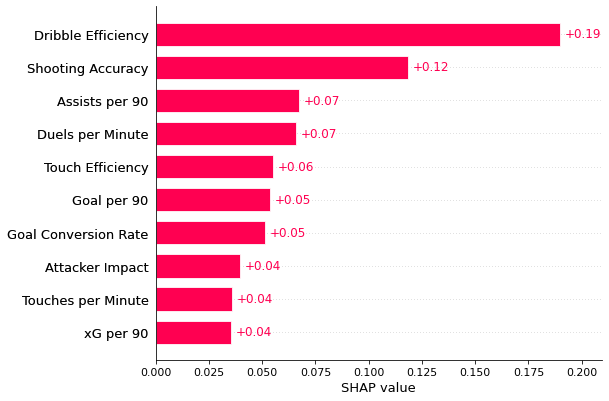

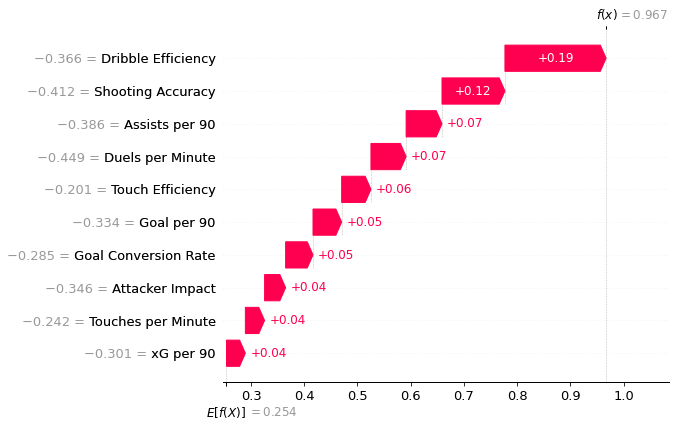


Processing SHAP for: Virgil van Dijk


ExactExplainer explainer: 571it [05:08,  1.79it/s]                         


🔍 SHAP Explanation for Player: Virgil van Dijk


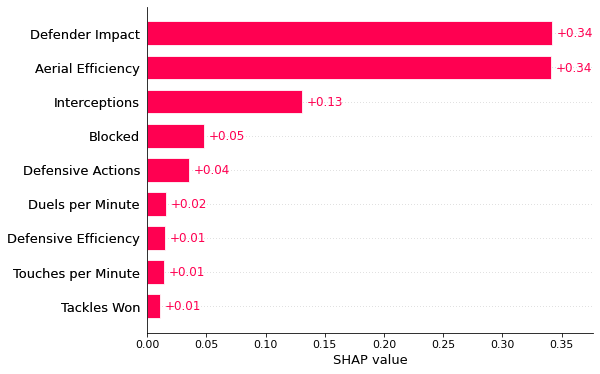

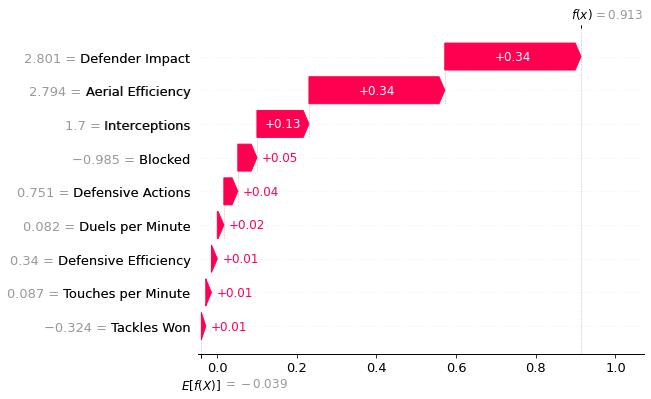

In [34]:
from sklearn.neighbors import KNeighborsRegressor
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# 🔹 List of players for SHAP analysis
input_players = ['Robert Lewandowski', 'Raphinha', 'Virgil van Dijk']

for input_player in input_players:
    print(f"\nProcessing SHAP for: {input_player}")

    if input_player not in df['Player Name'].values:
        print(f"Player '{input_player}' not found in dataset.")
        continue  # Skip to next player

    player_position = df.loc[df['Player Name'] == input_player, 'Position'].values[0]

    if player_position not in position_features:
        print(f"No features defined for position '{player_position}'.")
        continue

    features = position_features[player_position]
    pos_df = df[df['Position'] == player_position].copy().reset_index(drop=True)

    # Normalize & retain feature names
    scaler = StandardScaler()
    X_scaled_np = scaler.fit_transform(pos_df[features])
    X_scaled = pd.DataFrame(X_scaled_np, columns=features)

    # Cosine similarity
    input_idx = pos_df[pos_df['Player Name'] == input_player].index[0]
    similarities = cosine_similarity([X_scaled_np[input_idx]], X_scaled_np)[0]
    pos_df['Similarity'] = similarities

    # Train surrogate KNN model for SHAP
    knn = KNeighborsRegressor(n_neighbors=5)
    knn.fit(X_scaled, similarities)

    # SHAP explanation
    explainer = shap.Explainer(knn.predict, X_scaled)
    shap_values = explainer(X_scaled)

    print(f"🔍 SHAP Explanation for Player: {input_player}")
    shap.plots.bar(shap_values[input_idx], max_display=10)
    shap.plots.waterfall(shap_values[input_idx], max_display=10)
